# Capstone_Project_ALY6140_Crystal_Choi

< Data Set Summary > <br>
Title: Collisions—All Years. <br>
Description: This includes all types of collisions.  <br>
Timeframe: 2004 to Present.

Dataset URL:https://catalog.data.gov/dataset/collisions-9a73d <br>
Data explanation URL:https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf



## Goal of analysis
To understand what is causing the collision. <br>
To know what is the collision trend over months and years.<br>
To predict number of people that is involved in the collision. <br>
To predict collision severity level and type of collision, using different machine learning models.

## Hypothesis
1. Majority collsions are two vehicles hitting each oter. 
2. More collision happens during bad weather. 
3. More collision will happen during nighttime when there is less visibility.
4. Winter month has more collision.
5. Based on human and environmental causes, a machine learning model can be built to predict collision severity level and type of collision.


## Step 1 - Data extraction

1) Import libraries and load the downloaded CSV into dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv ("C:/Users/cryst/Downloads/ALY6140/Capstone/Collisions.csv")

## Step 2 - Data Clean-Up

2a) Create a new column "ColType" (to group 55 variables into 6 categories) from the column "ST_COLCODE"(State Collision Code). <br>

Based on dictionary at https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf <br>
"ColType" dictionary <br>
1 = hitting pedestrian. 2 = hitting Vehicle. 3 = hitting Cyclist. 4 = hitting Animal. 5 = hitting Object. 6 = other Miscellaneous. NA = not applicable

In [2]:
def summarizeColCode (row):
    try:
        code = int(row['ST_COLCODE'])
    except:
        return -1
    if (code >= 0 and code <=5):
        return 1
    elif (code >=10 and code <= 30)or(code >= 32 and code <= 43):
        return 2
    elif (code >= 44 and code <=46):
        return 3
    elif (code >= 47 and code <=49):
        return 4
    elif (code >= 50 and code <=51):
        return 5
    else:
        return 6
    
    
df["ColType"] = df.apply(lambda row : summarizeColCode(row), axis = 1 )

2b) Convert the column "UNDERINFL"(whether a driver was under the influence of drug or alcohol) "N" to 0 and "Y" to 1. Default empty values to 0.

In [3]:
def cleanUNDERINF (row):
    code = row['UNDERINFL']
    if ("N"==str(code)):
        return 0
    elif ("Y"== str(code)):
        return 1
    else:
        try:
            if(int(code) > 0):
                return int(code)
            else:
                return 0
        except:
            return 0

df["UNDERINFL"] = df.apply(lambda row : cleanUNDERINF(row), axis = 1 )

2c) Convert the column "SEVERITYCODE"(the severity of the collision) to int. Convert 2b to 3, 3 to 4, keep 0, 1, 2 the same, if not an integer make it -1

In [4]:
def cleanSEVERITYCODE (row):
    if("2b"== str(row['SEVERITYCODE'])):
        code = 3
    elif (row['SEVERITYCODE']==3):
        code = 4
    else:
        try:
            code = int(row['SEVERITYCODE'])
        except:
            return -1
    return code

df["SEVERITYCODE"] = df.apply(lambda row : cleanSEVERITYCODE(row), axis = 1 )

2d) Fill in the column "SPEEDING" (convert N to 0, Y to 1, empty to 0)
    

In [5]:
def cleanSPEEDING (row):
    code = row['SPEEDING']
    if ("N"==str(code)):
        return 0
    elif ("Y"== str(code)):
        return 1
    else:
        try:
            return int(code)
        except:
            return 0

df["SPEEDING"] = df.apply(lambda row : cleanSPEEDING(row), axis = 1 )

2e) Extract only needed Columns.

-Cause Columns: "UNDERINFL", "WEATHER", "ROADCOND", "LIGHTCOND", "PEDROWNOTGRNT", "SPEEDING"    

-Effect Columns: "SEVERITYCODE", "ColType", "PERSONCOUNT", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT", "INJURIES", "SERIOUSINJURIES", "FATALITIES", "HITPARKEDCAR"

Remove rows with incomplete data:
"ColType" < -1 and "SEVERITYCODE" <= 0<br>
Use get_dummies to convert categorical variable into dummy/indicator variables.

In [6]:
humancause = ["UNDERINFL", "SPEEDING"]
envcause = ["WEATHER", "ROADCOND", "LIGHTCOND"]
effect = ["SEVERITYCODE", "ColType", "PERSONCOUNT", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT", "INJURIES", "SERIOUSINJURIES", "FATALITIES", "HITPARKEDCAR"]

cleanTable = df[df.ColType > -1]
cleanTable = cleanTable[cleanTable.SEVERITYCODE > 0]

cleanEncodedCause  = pd.get_dummies(cleanTable.loc[:,humancause+envcause])
cleanEffect  = cleanTable.loc[:,effect]

## Step 3 - Data visualization 

3a) The number of collisions over years and by months

Text(0, 0.5, 'Number of Collision')

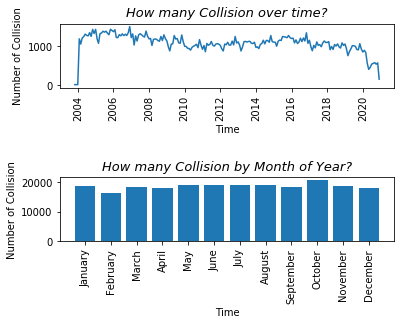

In [16]:
df['INCDTTM']= pd.to_datetime(df['INCDTTM'])

df_dates=pd.DataFrame(df.loc[:,["INCDTTM"]].to_numpy().flatten(),columns=["Date"]).groupby(pd.Grouper(key='Date', freq='M')).size().reset_index(name='Number_of_Collisions')
df_dates["Month"]=df_dates.apply(lambda row : row["Date"].month_name(),axis=1)
df_months = df_dates.groupby(by="Month").sum().reset_index()

d = dict(zip(pd.date_range('2000-01-01', freq='M', periods=12).strftime('%B'),range(1,13)))
df_months["month_number"]=df_months.apply(lambda row : d.get(row["Month"]),axis=1)
df_months = df_months.sort_values(by=['month_number'], ascending=True)

plt.subplot(3, 1, 1)
plt.plot(df_dates['Date'],df_dates['Number_of_Collisions'])
plt.title("How many Collision over time?", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xticks(rotation = 'vertical')
plt.xlabel("Time")
plt.ylabel("Number of Collision")

plt.subplot(3, 1, 3)
plt.bar(df_months['Month'],df_months['Number_of_Collisions'])
plt.title("How many Collision by Month of Year?", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xticks(rotation = 'vertical')
plt.xlabel("Time")
plt.ylabel("Number of Collision")





3b) Number of collision by collision types

"ColType" dictionary
1 = hitting pedestrian. 2 = hitting Vehicle. 3 = hitting Cyclist. 4 = hitting Animal. 5 = hitting Object. 6 = other Miscellaneous. NA = not applicable

ColType
1      8210
2    163619
3      5083
4        34
5     14655
6      4476
Name: SEVERITYCODE, dtype: int64


<function matplotlib.pyplot.show(*args, **kw)>

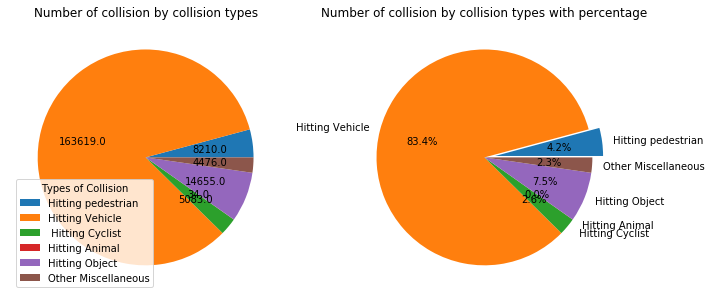

In [8]:
tempTable = cleanEffect.reset_index().groupby("ColType").count().iloc[:,1]
print(tempTable)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Number of collision by collision types')
plt.pie(
    x = tempTable,
    autopct=lambda val:np.round(val/100*tempTable.sum(),0)
)
plt.legend(labels=["Hitting pedestrian","Hitting Vehicle"," Hitting Cyclist","Hitting Animal","Hitting Object","Other Miscellaneous"],title="Types of Collision", loc="lower left")

plt.subplot(1, 2, 2)
plt.title('Number of collision by collision types with percentage')
plt.pie(
    x = tempTable, 
    explode=[0.1, 0, 0, 0, 0, 0],
    autopct='%0.1f%%',
    labels=["Hitting pedestrian","Hitting Vehicle"," Hitting Cyclist","Hitting Animal","Hitting Object","Other Miscellaneous"]
)
plt.tight_layout()
plt.show

3c) Number of collision by weather condition

Blowing Sand/Dirt               56
Blowing Snow                     1
Clear                       115352
Fog/Smog/Smoke                 631
Other                          871
Overcast                     28644
Partly Cloudy                   10
Raining                      34109
Severe Crosswind                26
Sleet/Hail/Freezing Rain       116
Snowing                        919
Unknown                      15129
dtype: int64


<BarContainer object of 12 artists>

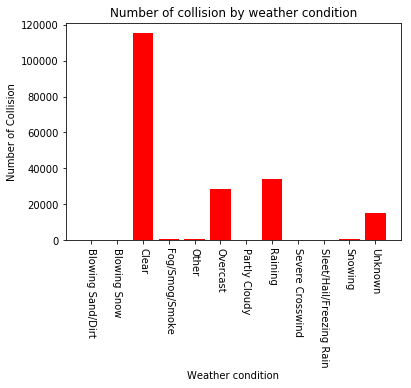

In [9]:
tempTable2 = pd.get_dummies(cleanTable.loc[:,"WEATHER"])
print(tempTable2.sum())

plt.title("Number of collision by weather condition")
plt.xlabel("Weather condition")
plt.ylabel("Number of Collision")
 
columnNames =tempTable2.columns
tempIndex = [ i for i,_ in enumerate(columnNames)]
plt.xticks(tempIndex, tempTable2.columns, rotation =-90)
plt.bar(tempIndex,tempTable2.sum(),color="red")

3d) Number of collision by time of a day

Blowing Sand/Dirt               56
Blowing Snow                     1
Clear                       115352
Fog/Smog/Smoke                 631
Other                          871
Overcast                     28644
Partly Cloudy                   10
Raining                      34109
Severe Crosswind                26
Sleet/Hail/Freezing Rain       116
Snowing                        919
Unknown                      15129
dtype: int64


<BarContainer object of 9 artists>

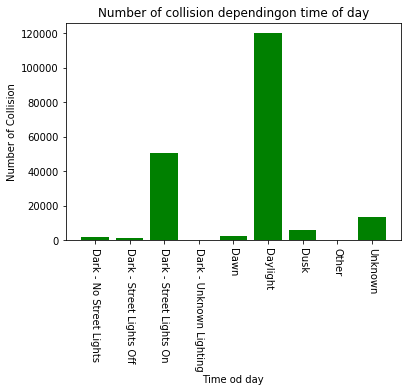

In [10]:
tempTable3 = pd.get_dummies(cleanTable.loc[:,"LIGHTCOND"])
print(tempTable2.sum())

plt.title("Number of collision dependingon time of day")
plt.xlabel("Time od day")
plt.ylabel("Number of Collision")
 
columnNames =tempTable3.columns
tempIndex = [ i for i,_ in enumerate(columnNames)]
plt.xticks(tempIndex, tempTable3.columns, rotation =-90)
plt.bar(tempIndex,tempTable3.sum(),color="green")

3e) Number of collision by Road condition

Blowing Sand/Dirt               56
Blowing Snow                     1
Clear                       115352
Fog/Smog/Smoke                 631
Other                          871
Overcast                     28644
Partly Cloudy                   10
Raining                      34109
Severe Crosswind                26
Sleet/Hail/Freezing Rain       116
Snowing                        919
Unknown                      15129
dtype: int64


<BarContainer object of 9 artists>

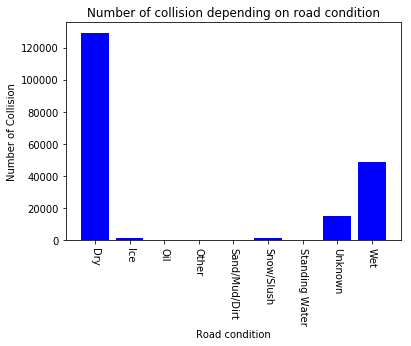

In [11]:
tempTable4 = pd.get_dummies(cleanTable.loc[:,"ROADCOND"])
print(tempTable2.sum())

plt.title("Number of collision depending on road condition")
plt.xlabel("Road condition")
plt.ylabel("Number of Collision")
 
columnNames =tempTable4.columns
tempIndex = [ i for i,_ in enumerate(columnNames)]
plt.xticks(tempIndex, tempTable4.columns, rotation =-90)
plt.bar(tempIndex,tempTable4.sum(),color="blue")

## Step 4 - Descriptive/Predictive analytics

4a) Prep data for Random Forest

In [12]:
colNum=1
results = np.array(cleanEffect.iloc[:,colNum])
print("Predicting: ",cleanEffect.columns[colNum])
    
inp = np.array(cleanEncodedCause)

# Split the data into training and testing sets
train_inp, test_inp, train_results, test_results = train_test_split(inp, results, test_size = 0.1,
                                                                           random_state = 0)

Predicting:  ColType


4b) Fit Data to Random Forest and Neural Network

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state = 0)

# Train the model on training data
rf.fit(train_inp, train_results)

# Use the forest's predict method on the test data
rf_predictions = rf.predict(test_inp)


In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(10, 2), random_state = 0)
mlp.fit(train_inp, train_results)
mlp_predictions = mlp.predict(test_inp)


4c) Analyze Result

In [15]:
def evalPrediction(predictions,title):
    print("\n*** ",title," ***")
    # Calculate the absolute errors
    errors = abs(predictions - test_results)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), '.')
    count_incorrent = 0
    
    for i in range(len(test_inp)):
        if(predictions[i] != test_results[i]):
            count_incorrent+=1
    print("Number of incorrect predictions:",count_incorrent)
    print("% of incorrect predictions:",count_incorrent/len(test_inp)*100)
    
    df = pd.DataFrame(predictions,columns=["value"]).groupby(by="value").size()
    print("Value Grouping:\n",df)
    
evalPrediction(rf_predictions, "Random Forest Classifier Results")
evalPrediction(mlp_predictions,"Multi-Layer Classifier Perceptron Results")


    


***  Random Forest Classifier Results  ***
Mean Absolute Error: 0.39 .
Number of incorrect predictions: 3309
% of incorrect predictions: 16.87576499388005
Value Grouping:
 value
1        1
2    19456
3        2
5      149
dtype: int64

***  Multi-Layer Classifier Perceptron Results  ***
Mean Absolute Error: 0.39 .
Number of incorrect predictions: 3287
% of incorrect predictions: 16.76356589147287
Value Grouping:
 value
2    19321
5      287
dtype: int64


4e) Predictive anaylsis summary:
I used a random forest and neural network to predict effects using different causes. I randeomly selected 10% as a test set, and using 90% to train the model. Both ML approaches yielded very similar results. Likely due to the high output bias from the data set (Most Colision types were vehicle to vehicle (1) and most Severity level 2). However the percentage error for the ML approach is higher than not using an ML model. In the case of colision type prediction, even the optimized ML model gave an 16-17% error rate, which is higher than if someone just chose 2 (most frequent outcome) for every single prediction which would have 16.6 error (see 3b). Due to this, the hypothesis that an ML classification model can be built to accurately predict the type and severity of collision based on human and environmental causes is false.

## Conclusion
Number of collisions has been moderately decreasing from 2004 to 2020.
The Number of collisions is steady throughout the year, with October being the highest. 

When it comes to collision type, hitting the vehicle accounted for the most portion which is 83.4%. Compared to other types(hitting object 7.5%, hitting a pedestrian 4.2%, hitting a cyclist 2.6%, other miscellaneous 2.3%)

Compared to the hypothesis that there will be more collisions when weather is bad, when the collision happened, the weather was mostly clear, not rainy or overcast. 

On the contrary of the hypothesis that collisions will happen more at night, the data shows that there is more number of collisions during daylight, not during night time.

There is a much higher number of collisions when the road is dry, not when it is with ice or oil.

This is understandable given that there are likely more cars on the road during the day, when the weather is good, and when the road condition is good.

Note: This does not represent the probability of getting into an accident during these conditions. To do that analysis , I need a dataset that includes non collision data, such as number of cars on the road during these times.

For machine learning, hypothesis that an ML classification model can be built to more accurately predict the type and severity of collision based on human and environmental causes is false. With this data set, even the optimized ML models could not provide a better result than just always picking the most statiscally common outcome.